In [2]:
import numpy as np
import matplotlib.pyplot as plt

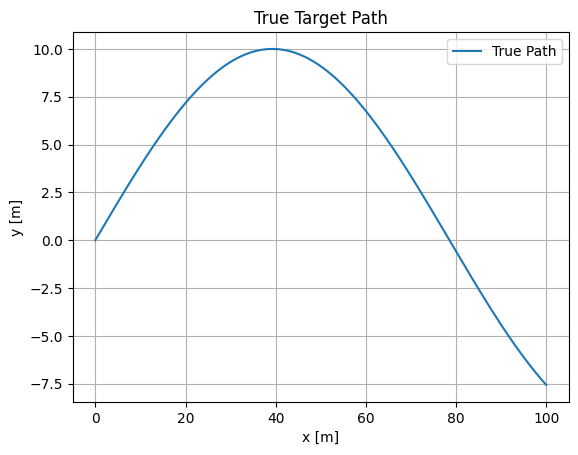

In [3]:
""" Simulating simple parametric motion """
dt = 0.1
T = 20
timesteps = int(T / dt)
t = np.linspace(0, T, timesteps)

v_x = 5
x = v_x * t
y = 10 * np.sin(0.2 * t)

true_pos = np.vstack((x, y)).T
true_vel = np.gradient(true_pos, dt, axis=0)

plt.plot(x, y, label='True Path')
plt.title("True Target Path")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
""" Radar and Camera Simulator """
est_dist, est_angle = [], []
for pos in true_pos:
    distance = np.sqrt(pos[0]**2 + pos[1]**2)
    bearing = np.arctan2(pos[1], pos[0])

    noisy_bearing = bearing + np.random.normal(0, np.deg2rad(1))
    noisy_distance = distance + np.random.normal(0, 0.5)
    
    est_dist.append(noisy_distance)
    est_angle.append(noisy_bearing)

In [5]:
""" Converting Polar to Cartesian Coordinates """
measured_pos = []
for r, theta in zip(est_dist, est_angle):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    measured_pos.append([x, y])

measured_pos = np.array(measured_pos)

In [6]:
""" Kalman Filter Setup """
# State = [x, y, v_x, v_y]^T
x_est = np.zeros((4, 1))
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

P = np.eye(4) * 500
Q = np.eye(4) * 0.05
R = np.eye(2) * 4
I = np.eye(4)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

In [7]:
""" Looping Through Filter """
# Note that @ is like dot product between two matrices
estimated_pos = []
for z in measured_pos:
    z = z.reshape(2, 1)
    x_est = F @ x_est
    P = F @ P @ F.T + Q
    res = z - H @ x_est
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    
    P = (I - K @ H) @ P
    x_est = x_est + K @ res

    estimated_pos.append(x_est[:2].flatten())

estimated_pos = np.array(estimated_pos)

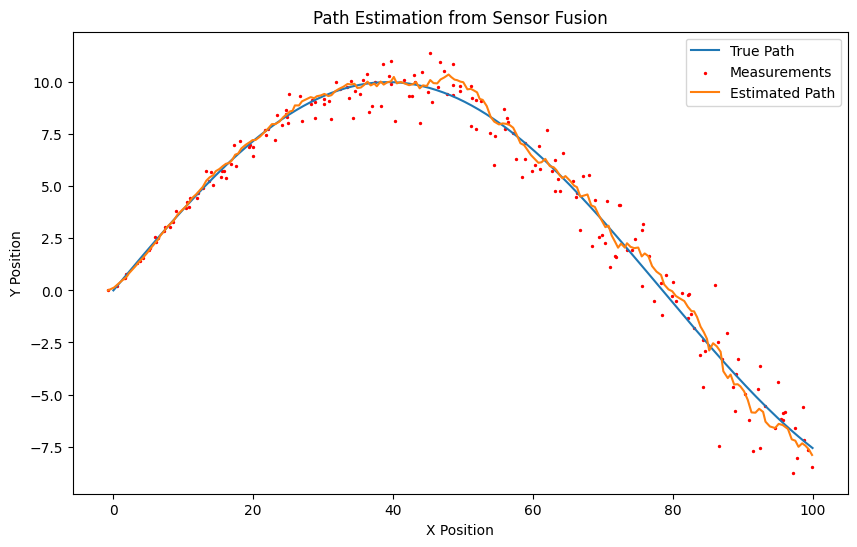

In [9]:
""" Visualising Results """
true_x, true_y = true_pos[:, 0], true_pos[:, 1]
meas_x, meas_y = measured_pos[:, 0], measured_pos[:, 1]
est_x, est_y = estimated_pos[:, 0], estimated_pos[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(true_x, true_y, label='True Path')
plt.scatter(meas_x, meas_y, label='Measurements', s=2, color='red')
plt.plot(est_x, est_y, label='Estimated Path')
plt.title("Path Estimation from Sensor Fusion")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.show()